📦 Libraries Used

In [1]:
import os
import time
import string
import requests
import multiprocessing as mp
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

📚 NLTK Resource Setup

In [2]:

# Download NLTK resources if not available
nltk_dependencies = ['punkt', 'punkt_tab', 'stopwords']

for resource in nltk_dependencies:
    try:
        nltk.data.find(f'tokenizers/{resource}' if 'punkt' in resource else f'corpora/{resource}')
    except LookupError:
        print(f"Downloading NLTK resource: {resource}")
        nltk.download(resource)


1️⃣ Automatically Download 50+ Books from Project Gutenberg

In [3]:

def download_gutenberg_texts(num_books: int = 50) -> List[str]:
    base_url = "https://www.gutenberg.org/files/{id}/{id}-0.txt"
    books_directory = "gutenberg_books"
    os.makedirs(books_directory, exist_ok=True)

    downloaded_books = []
    book_id = 100
    attempts = 0
    max_attempts = num_books * 6

    print(f"\nDownloading {num_books} books...\n")
    with tqdm(total=num_books, desc="Downloading books") as pbar:
        while len(downloaded_books) < num_books and attempts < max_attempts:
            url = base_url.format(id=book_id)
            try:
                response = requests.get(url, timeout=10)
                if response.status_code == 200 and len(response.text) > 10000:
                    filename = os.path.join(books_directory, f"{book_id}.txt")
                    with open(filename, 'w', encoding='utf-8') as f:
                        f.write(response.text)
                    downloaded_books.append(filename)
                    pbar.update(1)
            except:
                pass
            book_id += 1
            attempts += 1

    print(f"\n✓ Books downloaded: {len(downloaded_books)}\n")
    return downloaded_books



2️⃣ Text Preprocessing by Paragraph

In [4]:

def preprocess_text(text: str) -> List[str]:
    paragraphs = text.split('\n\n')
    all_tokens = []

    stop_words = set(stopwords.words('english'))

    for para in paragraphs:
        para = para.strip().lower()
        para = para.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(para)
        filtered = [t for t in tokens if t.isalpha() and t not in stop_words]
        all_tokens.extend(filtered)

    return all_tokens



3️⃣ Serial Word Frequency Analysis

In [5]:

def serial_word_frequency(book_paths: List[str]) -> Dict[str, Dict[str, int]]:
    all_frequencies = {}

    for book_path in tqdm(book_paths, desc="Processing (serial)"):
        try:
            with open(book_path, 'r', encoding='utf-8') as f:
                text = f.read()
                tokens = preprocess_text(text)
                freq = {}
                for token in tokens:
                    freq[token] = freq.get(token, 0) + 1
                book_name = os.path.basename(book_path)
                all_frequencies[book_name] = freq
        except Exception as e:
            print(f"Error processing {book_path}: {e}")

    return all_frequencies



🔸 Top Words per Book

In [6]:

def top_words_per_book(book_paths: List[str], word_counts: Dict[str, Dict[str, int]], top_n: int = 5):
    print("\n📚 Top words per book (Serial):\n")
    for book_path in book_paths:
        book_name = os.path.basename(book_path)
        if book_name in word_counts:
            freqs = word_counts[book_name]
            top_words = sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:top_n]
            print(f"🔸 {book_name}:")
            for word, count in top_words:
                print(f"   {word}: {count}")
            print()



4️⃣ Parallel Word Frequency Analysis

In [7]:

def process_book(book_path: str) -> Dict[str, int]:
    try:
        with open(book_path, 'r', encoding='utf-8') as f:
            text = f.read()
            tokens = preprocess_text(text)
            word_freq = {}
            for token in tokens:
                word_freq[token] = word_freq.get(token, 0) + 1
        return word_freq
    except Exception as e:
        print(f"Error processing {book_path}: {e}")
        return {}

def parallel_word_frequency(book_paths: List[str], num_processes: int = None) -> Dict[str, int]:
    with mp.Pool(processes=num_processes) as pool:
        book_frequencies = pool.map(process_book, book_paths)

    word_freq = {}
    for book_freq in book_frequencies:
        for word, count in book_freq.items():
            word_freq[word] = word_freq.get(word, 0) + count

    return word_freq



5️⃣ Benchmark & Visualization

In [8]:

def benchmark_processing(book_paths: List[str], max_processes: int = None):
    if max_processes is None:
        max_processes = mp.cpu_count()

    # Serial
    start_serial = time.time()
    serial_freq = serial_word_frequency(book_paths)
    serial_time = time.time() - start_serial

    # Global Top 10
    print("\n🔝 Top 10 most frequent words (Serial):")
    global_freq = {}
    for freq_dict in serial_freq.values():
        for word, count in freq_dict.items():
            global_freq[word] = global_freq.get(word, 0) + count
    top_words = sorted(global_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    for word, count in top_words:
        print(f"{word}: {count}")

    # Top words per book
    top_words_per_book(book_paths, serial_freq)

    # Parallel
    process_times = []
    num_processes_list = list(range(1, max_processes + 1))

    for num_processes in num_processes_list:
        start_parallel = time.time()
        parallel_freq = parallel_word_frequency(book_paths, num_processes)
        parallel_time = time.time() - start_parallel
        process_times.append(parallel_time)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(num_processes_list, process_times, marker='o')
    plt.axhline(y=serial_time, color='r', linestyle='--', label='Serial time')
    plt.title('Parallel Processing: Execution Time vs Number of Processes')
    plt.xlabel('Number of Processes')
    plt.ylabel('Execution Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\n⏱️ Serial processing time: {serial_time:.4f} seconds")
    print(f"⚡ Fastest parallel processing time: {min(process_times):.4f} seconds")



🚀 Main Entry Point


✓ Books downloaded: 50



Processing (serial): 100%|██████████| 50/50 [00:31<00:00,  1.61it/s]



🔝 Top 10 most frequent words (Serial):
said: 18486
one: 18121
would: 16950
could: 12383
man: 11488
upon: 9619
like: 9531
time: 8941
good: 8491
come: 8395

📚 Top words per book (Serial):

🔸 100.txt:
   thou: 5924
   thy: 4353
   shall: 3855
   thee: 3411
   king: 3200

🔸 101.txt:
   computer: 462
   service: 287
   people: 286
   one: 247
   hackers: 233

🔸 102.txt:
   en: 334
   de: 304
   tom: 255
   said: 249
   would: 215

🔸 104.txt:
   must: 10
   national: 9
   people: 9
   may: 8
   leadership: 7

🔸 105.txt:
   anne: 496
   could: 451
   would: 355
   captain: 303
   mrs: 291

🔸 106.txt:
   tarzan: 927
   upon: 487
   would: 296
   one: 248
   great: 240

🔸 107.txt:
   said: 982
   bathsheba: 573
   upon: 404
   man: 396
   oak: 386

🔸 108.txt:
   holmes: 748
   said: 496
   one: 441
   upon: 413
   mr: 410

🔸 109.txt:
   little: 27
   would: 25
   thee: 23
   like: 23
   could: 21

🔸 110.txt:
   tess: 884
   said: 589
   would: 513
   one: 477
   could: 466

🔸 111.txt:
   freck

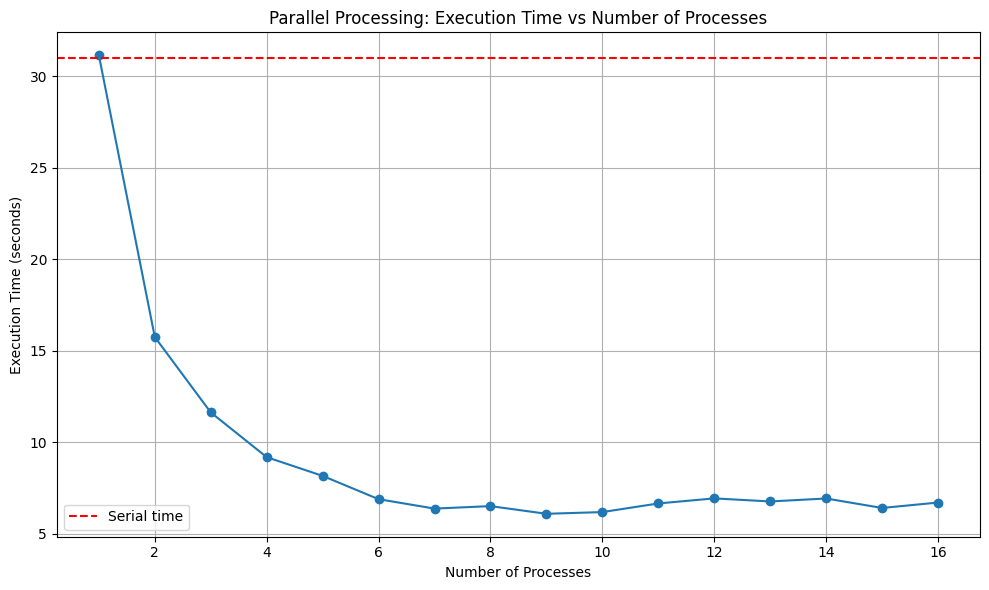


⏱️ Serial processing time: 31.0320 seconds
⚡ Fastest parallel processing time: 6.0821 seconds


In [9]:
def main():
    book_paths = download_gutenberg_texts(num_books=50)
    benchmark_processing(book_paths)

if __name__ == "__main__":
    main()
